# Exploración de datos

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Estadística descriptiva y pruebas de normalidad
from scipy.stats import skew, kurtosis, jarque_bera, shapiro
from scipy import stats

# Modelado y diagnóstico estadístico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

* Cargar datos
```{note}
Se analizan los datos después del preprocesamiento.

In [2]:
# Lectura de archivo y selección de variables de interés
btc = pd.read_csv(r"C:\Users\Hp\MACHINE\MINI_PRY_2\data\BTC_all.csv")
btc['Date'] = pd.to_datetime(btc['Date'], errors='coerce', format='%Y-%m-%d')
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2566 entries, 0 to 2565
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2566 non-null   datetime64[ns]
 1   Close        2566 non-null   float64       
 2   log_return   2566 non-null   float64       
 3   Volatil_D7   2566 non-null   float64       
 4   Volatil_D14  2566 non-null   float64       
 5   Volatil_D21  2566 non-null   float64       
 6   Volatil_D28  2566 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 140.5 KB


## 1. Precio de cierre

In [3]:
btc['Close'].describe()

count      2566.000000
mean      29264.276684
std       23644.382719
min        3211.720000
25%        8979.587500
50%       23067.550000
75%       43782.805000
max      106143.820000
Name: Close, dtype: float64

In [4]:
mean = btc['Close'].mean()
std = btc['Close'].std()

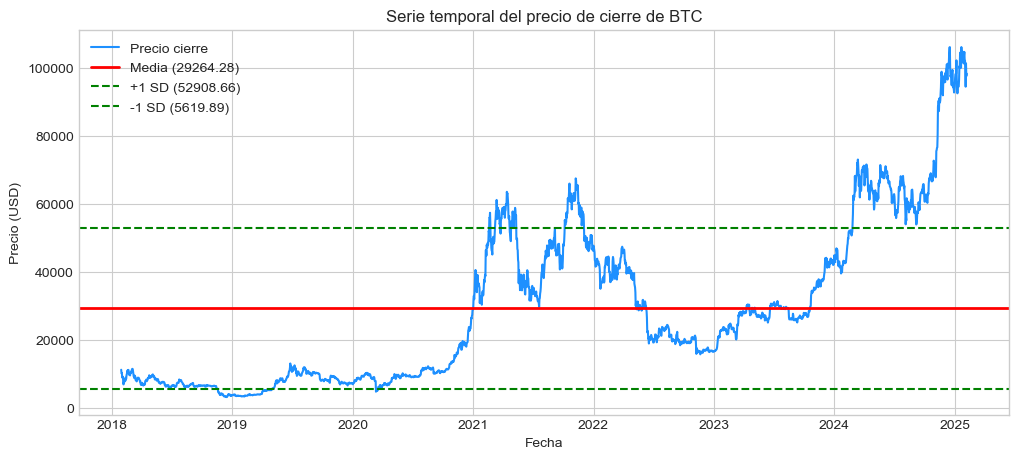

In [5]:
plt.figure(figsize=(12,5))
plt.plot(btc['Date'], btc['Close'], label="Precio cierre", color = 'dodgerblue')
# Línea de la media
plt.axhline(mean, color='red', linestyle='-', linewidth=2, label=f"Media ({mean:.2f})")

# Líneas punteadas ±1 desviación estándar
plt.axhline(mean + std, color='green', linestyle='--', linewidth=1.5, label=f"+1 SD ({mean+std:.2f})")
plt.axhline(mean - std, color='green', linestyle='--', linewidth=1.5, label=f"-1 SD ({mean-std:.2f})")

plt.title("Serie temporal del precio de cierre de BTC")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.legend()
plt.show()

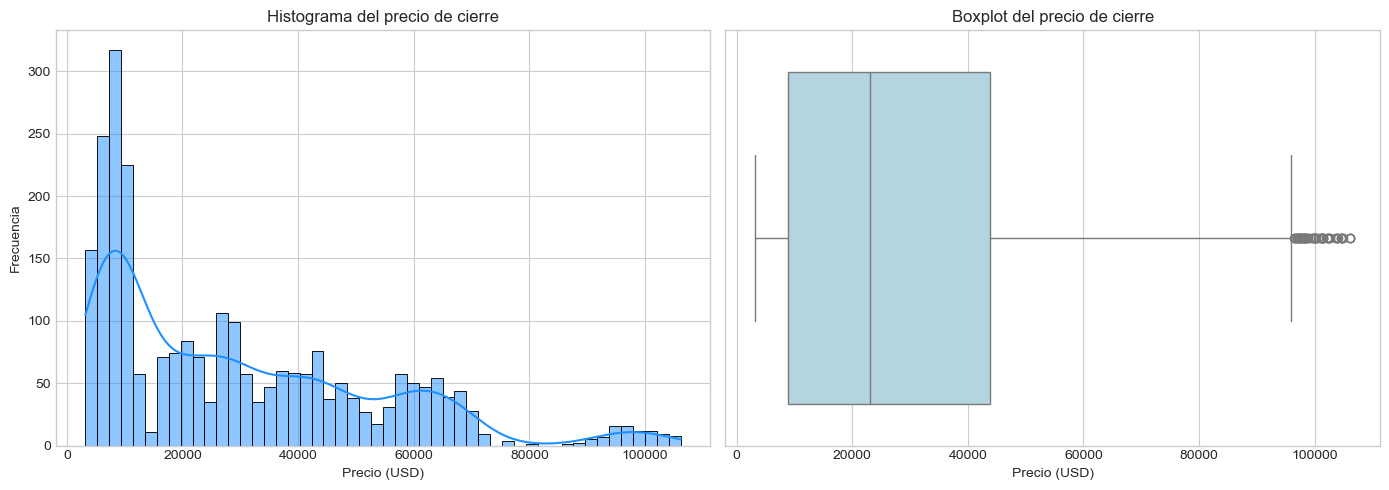

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
sns.histplot(btc['Close'], bins=50, kde=True, ax=axes[0], color='dodgerblue')
axes[0].set_title('Histograma del precio de cierre')
axes[0].set_xlabel('Precio (USD)')
axes[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=btc['Close'], ax=axes[1], color='lightblue')
axes[1].set_title('Boxplot del precio de cierre')
axes[1].set_xlabel('Precio (USD)')

plt.tight_layout()
plt.show()


De los 2,594 registros, el precio de cierre de BTC varía entre USD $3,211$ y USD $106,143$. El promedio en el periodo fue de USD $29,090$ ($\pm 23,576$), mientras que la mediana alcanzó USD $22,741$. La diferencia entre la mediana y la mediana, junto con la alta desviación estándar, evidencia una volatilidad extreman y sugiere que la distribución de precios no sigue una normalidad. 

En la serie temporal del precio de cierre, se observa que entre 2018 a 202 predominaban los valores más bajos. A partir del 2021 se registra un incremento abrupto, con precios que superan la media más de una desviación estándar. Posteriormente, entre finales de 2021 y 2022, el BTC experimenta una marcada alta variabilidad, seguida de una caída en 2023. Desde entonces, se aprecia una recuperación que continua. El año 2024 también muestra alta variabilidad. Al final se registra un pico de aumento hacia finales del 2025, con los valores más altos del registro. 

La distribución del precio presenta una clara asimetría positiva, impulsada por los valores máximos alcanzados en los últimos años.

* interpretacion

## 2. Retornos logarítmicos

In [7]:
# Limpiar datos (eliminar NaN e infinitos)
returns = btc['log_return'].replace([np.inf, -np.inf], np.nan).dropna()
returns.describe()

count    2566.000000
mean        0.000824
std         0.035672
min        -0.502607
25%        -0.014141
50%         0.000658
75%         0.016119
max         0.178449
Name: log_return, dtype: float64

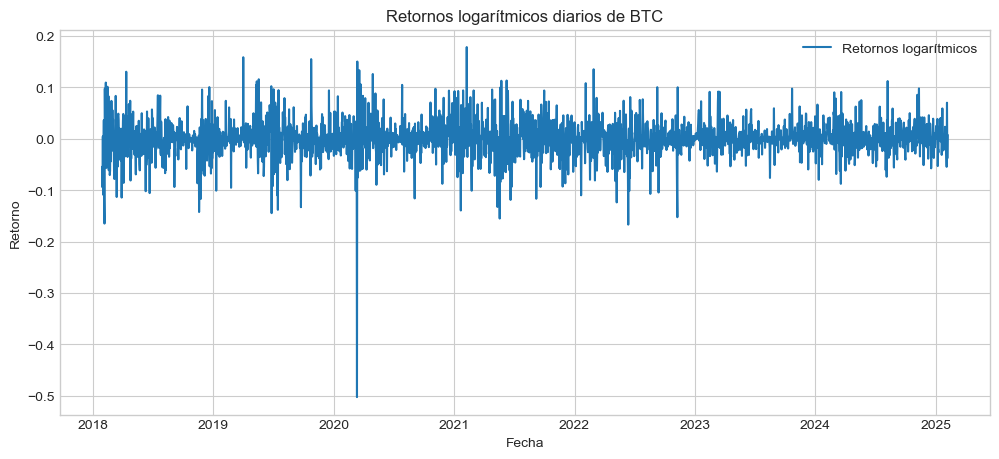

In [8]:
plt.figure(figsize=(12,5))
plt.plot(btc['Date'], btc['log_return'], label="Retornos logarítmicos")
plt.title("Retornos logarítmicos diarios de BTC")
plt.xlabel("Fecha")
plt.ylabel("Retorno")
plt.legend()
plt.show()

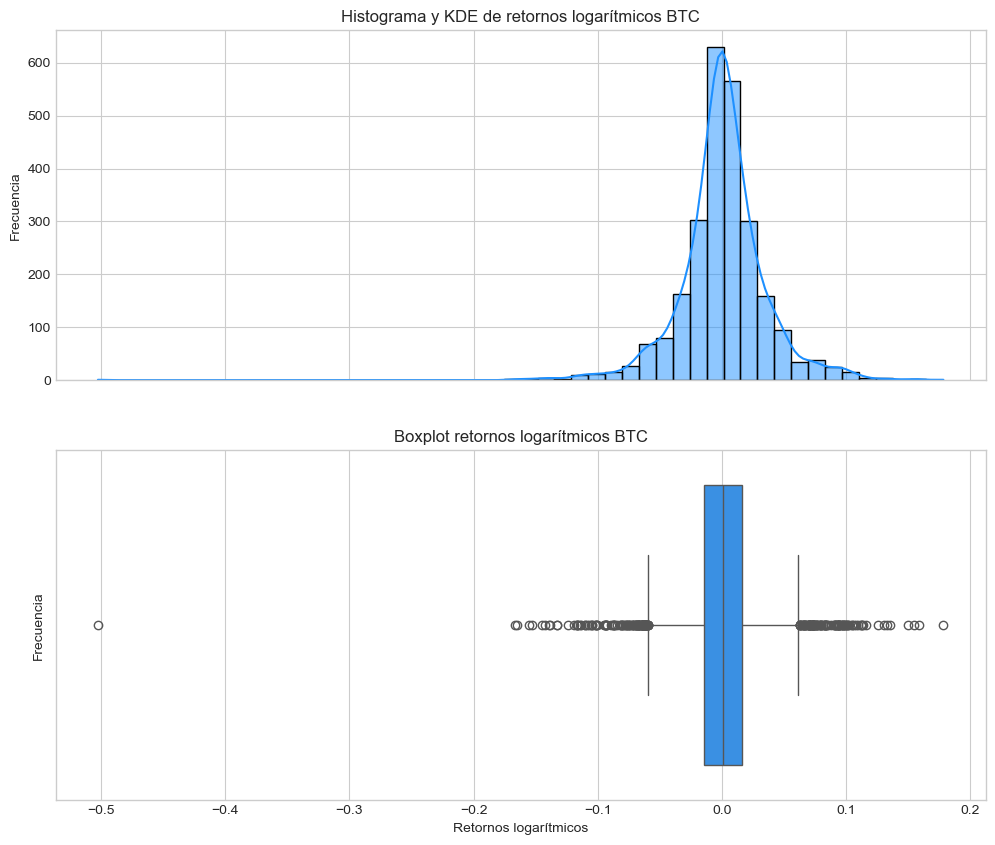

In [9]:
# --- 4. Histogram + KDE ---

fig, axes = plt.subplots(2,1, figsize = (12,10), sharex = True)

sns.histplot(btc['log_return'], kde=True, ax=axes[0], color='dodgerblue', bins=50)
axes[0].set_title("Histograma y KDE de retornos logarítmicos BTC")
axes[0].set_xlabel("Retornos logarítmicos")
axes[0].set_ylabel("Frecuencia")

sns.boxplot(x=btc['log_return'], color='dodgerblue', ax=axes[1])
axes[1].set_title("Boxplot retornos logarítmicos BTC")
axes[1].set_xlabel("Retornos logarítmicos")
axes[1].set_ylabel("Frecuencia")

plt.show()

Los retornos logarítmicos diarios de Bitcoin muestran una distribución centrada en cero, con una media de 0.000769 y una mediana de 0.000708, lo que indica que en la mayoría de los días el cambio porcentual fue pequeño y positivo. Sin embargo, la desviación estándar de 0.0362 revela una alta volatilidad diaria. 

El gráfico de retornos logarítmicos diarios muestra la volatilidad: la mayoría de los retornos se agrupan cerca del eje horizontal, pero hay varios picos y caídas abruptas que sobresalen del patrón general. El evento más notable ocurre alrededor de 2020, donde se observa una caída pronunciada que coincide con el mínimo estadístico de -0.5026.


* Prueba de normalidad

In [10]:
# 3. Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(returns)

# 4. Jarque-Bera
jb_stat, jb_p = jarque_bera(returns)

print("Prueba de normalidad sobre retornos logarítmicos (limpios)")
print(f"Shapiro-Wilk: estadístico = {shapiro_stat:.4f}, p-valor = {shapiro_p:.4e}")
print(f"Jarque-Bera: estadístico = {jb_stat:.4f}, p-valor = {jb_p:.4e}")



Prueba de normalidad sobre retornos logarítmicos (limpios)
Shapiro-Wilk: estadístico = 0.9061, p-valor = 3.9137e-37
Jarque-Bera: estadístico = 34303.4305, p-valor = 0.0000e+00


Evaluamos la normalidad de la distribución de retornos logarítmicos. Utilizamos Shapiro-Wilk test y Jarque-Bera test. De acuerdo con los resultados estadísticos de Jarque-Bera test, el estadístico es un valor muy grande, un p-valor muy cercano a 0, lo que lleva a rechazar la hipótesis de normalidad. 

In [11]:
# Calcular asimetría y curtosis
skewness = skew(returns)
kurt = kurtosis(returns, fisher=False)  # fisher=False -> curtosis "normal" (3 en normalidad)

print(f"Asimetría (Skewness): {skewness:.4f}")
print(f"Curtosis: {kurt:.4f}")

Asimetría (Skewness): -1.1404
Curtosis: 20.7663


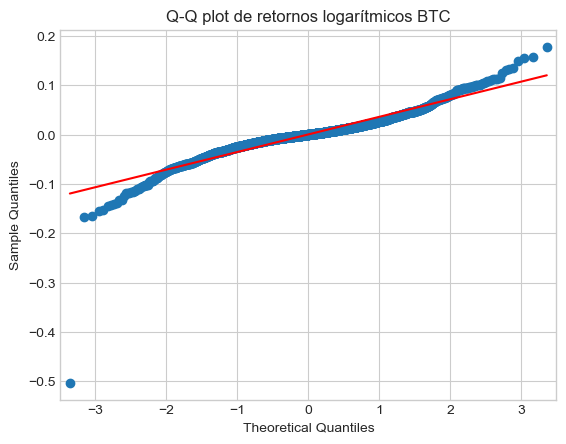

In [12]:
# --- 5. Q-Q Plot ---
sm.qqplot(btc['log_return'], line='s')
plt.title("Q-Q plot de retornos logarítmicos BTC")
plt.show()

** Falta interpretación

* Estacionariedad

In [13]:
adf_returns = adfuller(returns)
print("Prueba ADF en retornos:")
print(f"Estadístico ADF: {adf_returns[0]:.4f}")
print(f"p-valor: {adf_returns[1]:.4f}\n")

Prueba ADF en retornos:
Estadístico ADF: -24.0255
p-valor: 0.0000



### Función de autocorrelación (ACF) de retornos

Autocorrelación y heterocedasticidad

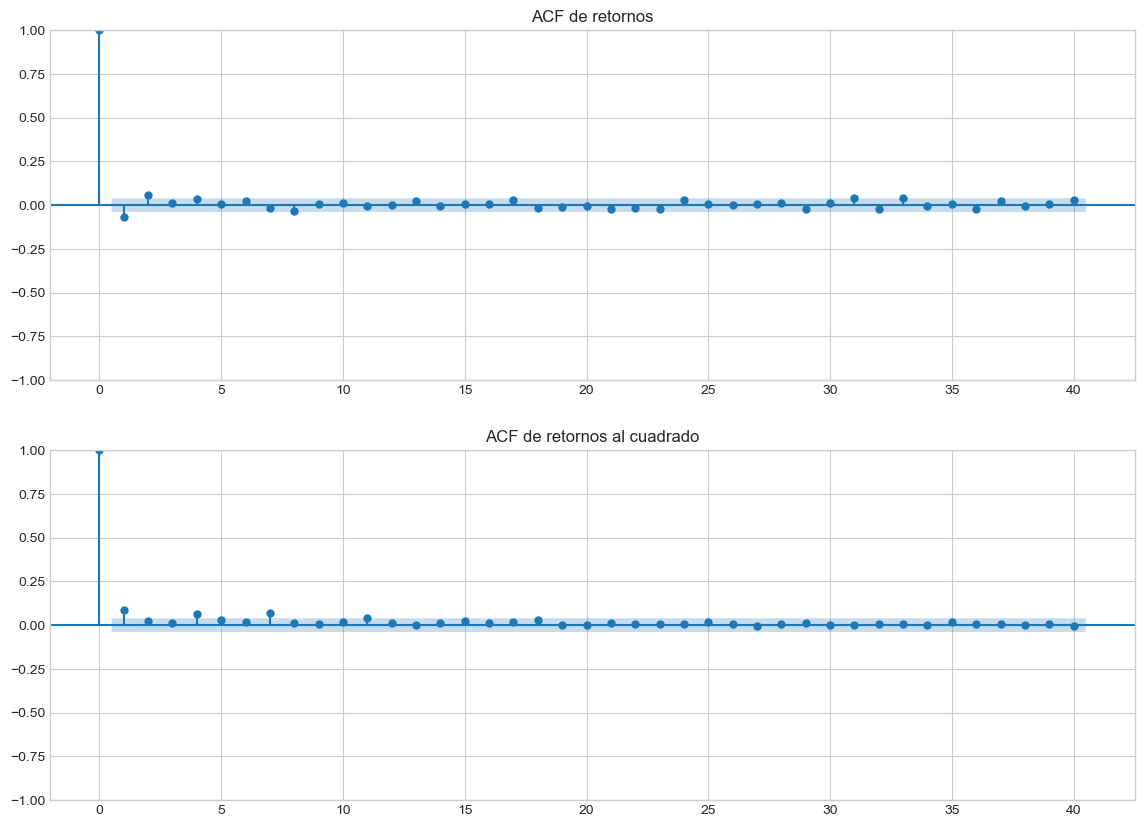

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(14,10))
plot_acf(returns, lags=40, ax=axes[0])
axes[0].set_title("ACF de retornos")

plot_acf(returns**2, lags=40, ax=axes[1])
axes[1].set_title("ACF de retornos al cuadrado")
plt.show()


* Interpretación

## 4. Volatilidad historica

#### Descripción

In [15]:
btc.columns

Index(['Date', 'Close', 'log_return', 'Volatil_D7', 'Volatil_D14',
       'Volatil_D21', 'Volatil_D28'],
      dtype='object')

In [16]:
tabla_vol = {}
ventanas = [7,14,21,28]

for dia in ventanas:
    col = f"Volatil_D{dia}"
    tabla_vol[f"{dia} días"] = btc[col].describe()

df_vol = pd.DataFrame(tabla_vol).T
df_vol = df_vol[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]  # Orden lógico
df_vol = df_vol.map(lambda x: f"{x:.4f}")

df_vol


,count,mean,std,min,25%,50%,75%,max
7 días,2566.0000,0.5856,0.3462,0.0584,0.3633,0.5222,0.7380,4.0397
14 días,2566.0000,0.6094,0.3057,0.1031,0.4127,0.5663,0.7254,3.0092
21 días,2566.0000,0.6209,0.2863,0.1252,0.4362,0.5775,0.7367,2.4849
28 días,2566.0000,0.6291,0.2728,0.1644,0.4576,0.5785,0.7365,2.1737


#### Distribución

C:\Users\Hp\AppData\Local\Temp\ipykernel_33836\3960112699.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ventana', y='Volatilidad', data=df_volatilidad_largo, palette='Blues')


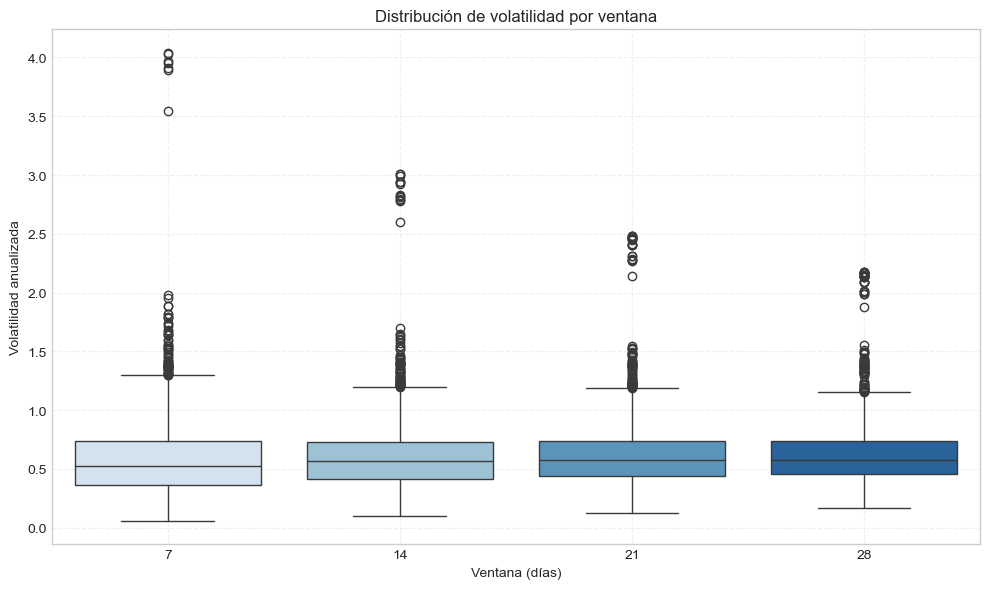

In [17]:
vol_cols = [f"Volatil_D{v}" for v in ventanas]

df_volatilidad_largo = pd.melt(
    btc[vol_cols],
    var_name='Ventana',
    value_name='Volatilidad'
)

# 2. Limpiar etiquetas si deseas que se vean como "7", "14", etc.
df_volatilidad_largo['Ventana'] = df_volatilidad_largo['Ventana'].str.extract(r'(\d+)').astype(int)

# 3. Graficar los boxplots en un solo gráfico
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ventana', y='Volatilidad', data=df_volatilidad_largo, palette='Blues')

plt.title('Distribución de volatilidad por ventana')
plt.xlabel('Ventana (días)')
plt.ylabel('Volatilidad anualizada')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

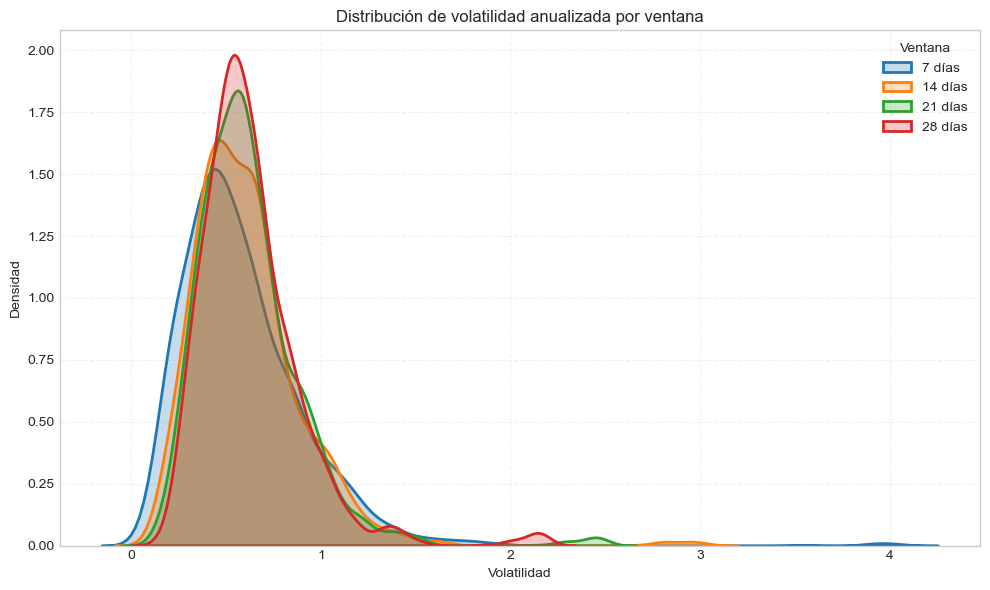

In [18]:
plt.figure(figsize=(10, 6))

for v in ventanas:
    col = f"Volatil_D{v}"
    sns.kdeplot(btc[col].dropna(), label=f'{v} días', linewidth=2, fill=True)

plt.title('Distribución de volatilidad anualizada por ventana')
plt.xlabel('Volatilidad')
plt.ylabel('Densidad')
plt.legend(title='Ventana')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


#### Análisis de normalidad

In [19]:
resultados = []

for v in ventanas:
    col = f"Volatil_D{v}"
    serie = btc[col].dropna()

    # Pruebas de normalidad
    shapiro_stat, shapiro_p = shapiro(serie)
    jb_stat, jb_p = jarque_bera(serie)

    resultados.append({
        'Ventana': f'{v}d',
        'Shapiro-Wilk (stat)': round(shapiro_stat, 4),
        'Shapiro-Wilk (p)': f"{shapiro_p:.4e}",
        'Jarque-Bera (stat)': round(jb_stat, 4),
        'Jarque-Bera (p)': f"{jb_p:.4e}"
    })

# Convertir a tabla
df_normalidad = pd.DataFrame(resultados).set_index('Ventana')
df_normalidad

,Shapiro-Wilk (stat),Shapiro-Wilk (p),Jarque-Bera (stat),Jarque-Bera (p)
Ventana,,,,
7d,0.8175,3.3458e-47,59722.7860,0.0000e+00
14d,0.8301,4.7016e-46,28403.7315,0.0000e+00
21d,0.8423,7.0816e-45,15006.0162,0.0000e+00
28d,0.8484,2.8766e-44,9325.4569,0.0000e+00


In [20]:
resultados = []
for v in ventanas:
    col = f"Volatil_D{v}"
    serie = btc[col].dropna()

    resultados.append({
        'Ventana': f'{v}d',
        'Asimetría': round(skew(serie), 4),
        'Curtosis': round(kurtosis(serie, fisher=False), 4)  # fisher=False → compara con normal (valor esperado = 3)
    })

df_asim_kurt = pd.DataFrame(resultados).set_index('Ventana')
df_asim_kurt


,Asimetría,Curtosis
Ventana,,
7d,3.0494,25.8341
14d,2.6499,18.4134
21d,2.3340,13.8887
28d,2.1402,11.3006


📌 ¿Qué significan?
- Asimetría (skewness):
Mide la simetría de la distribución.
- Valor ≈ 0 → distribución simétrica.
- Valor > 0 → sesgo a la derecha (colas largas positivas).
- Valor < 0 → sesgo a la izquierda (colas largas negativas).
- Curtosis (kurtosis):
Mide la concentración de masa en los extremos.
- Valor ≈ 3 → distribución normal.
- Valor > 3 → leptocúrtica (colas pesadas, más extremos).
- Valor < 3 → platicúrtica (menos extremos que la normal).


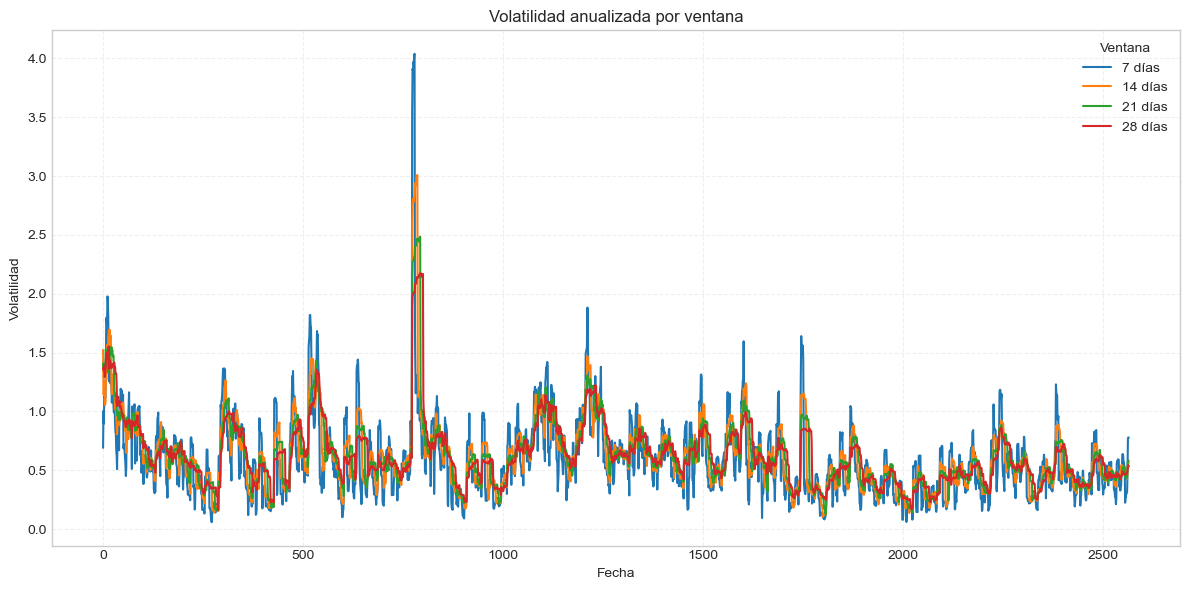

In [21]:
plt.figure(figsize=(12, 6))

for v in ventanas:
    plt.plot(btc.index, btc[f"Volatil_D{v}"], label=f'{v} días', linewidth=1.5)

plt.title('Volatilidad anualizada por ventana')
plt.xlabel('Fecha')
plt.ylabel('Volatilidad')
plt.legend(title='Ventana')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

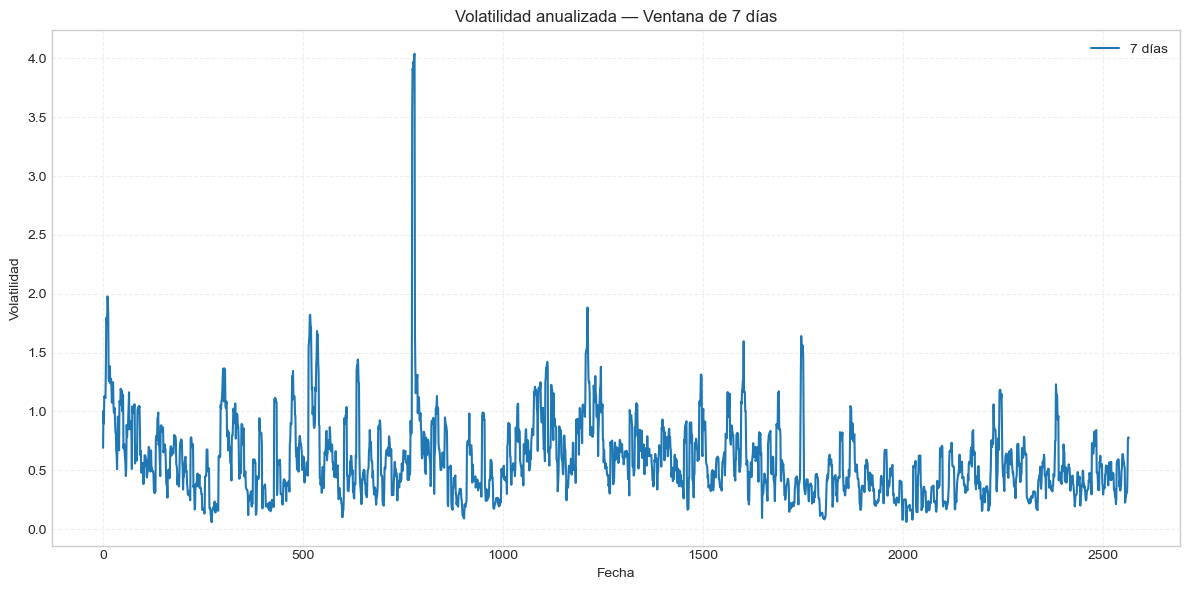

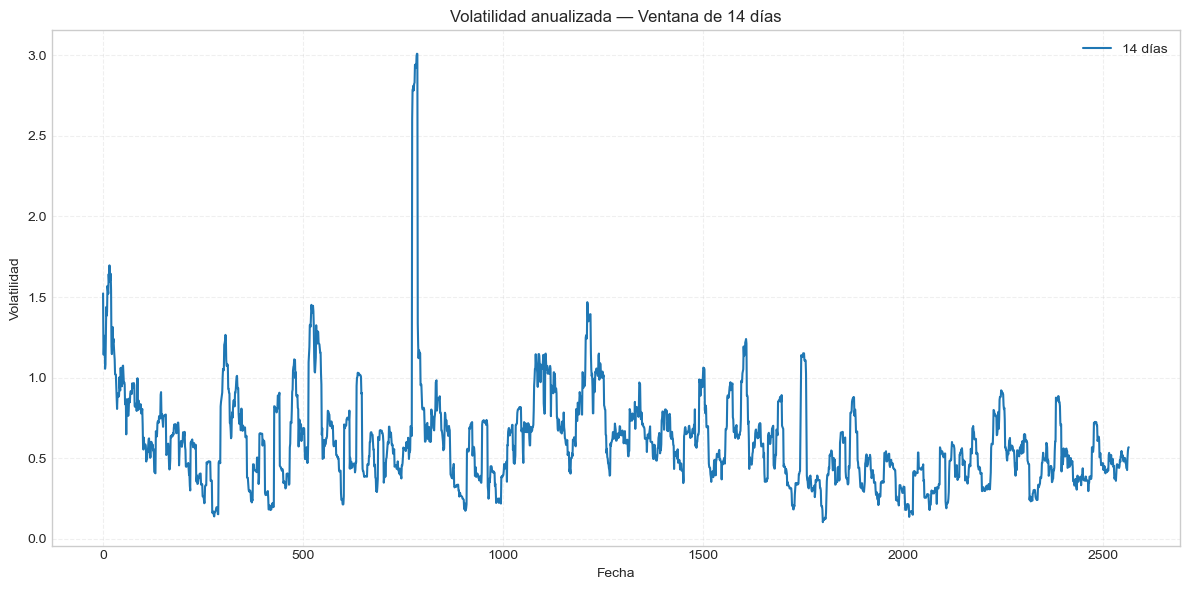

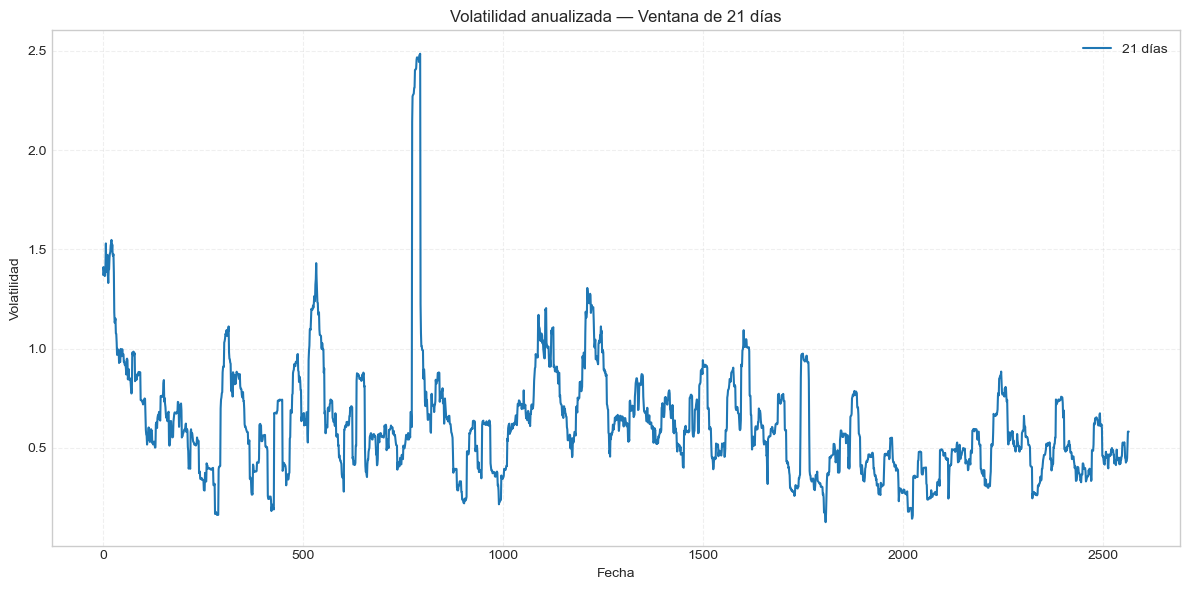

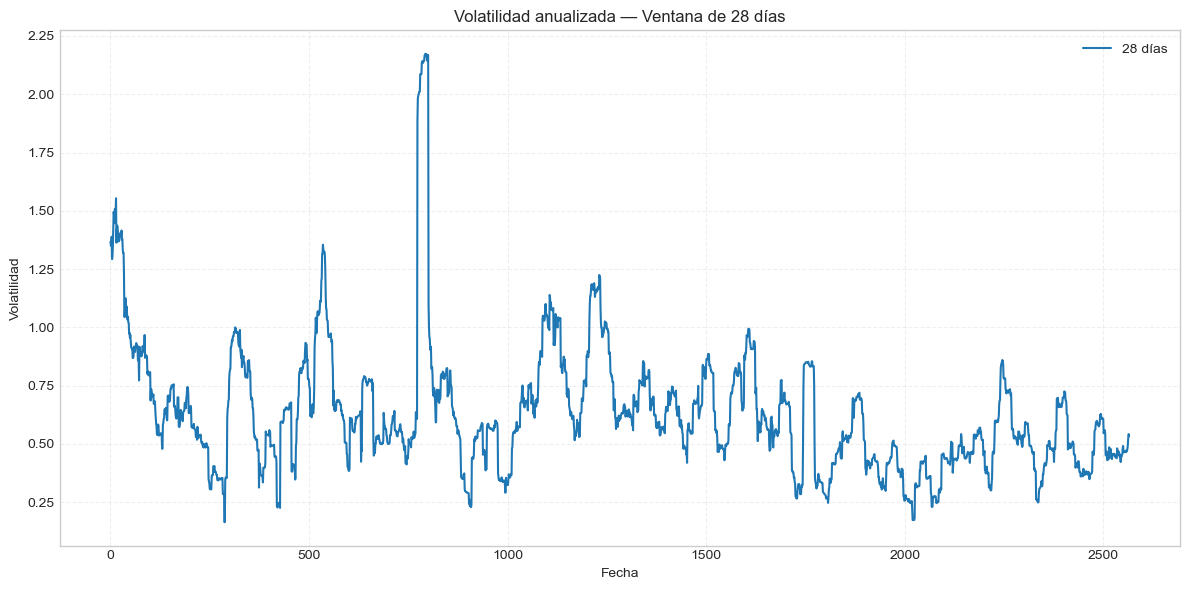

In [23]:
for v in ventanas:
    plt.figure(figsize=(12, 6))
    plt.plot(btc.index, btc[f"Volatil_D{v}"], label=f'{v} días', linewidth=1.5)
    
    plt.title(f'Volatilidad anualizada — Ventana de {v} días')
    plt.xlabel('Fecha')
    plt.ylabel('Volatilidad')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

#### Analisis de dependencia temporal por ventana

* ACF y PACF

🔍 Interpretación del ACF (Autocorrelation Function)
- Decaimiento lento y significativo en varios rezagos → indica persistencia: la volatilidad de hoy está correlacionada con la de días anteriores.
- Esto sugiere agrupamiento de volatilidad (volatility clustering), típico en activos financieros.
- No es ruido blanco: hay estructura temporal que puede ser modelada.
📌 Implicación técnica: puedes justificar modelos como GARCH, que capturan esta dependencia condicional.

🔍 Interpretación del PACF (Partial Autocorrelation Function)
- Pico fuerte en lag 1, posiblemente en lag 2 → indica que la volatilidad depende directamente de 1 o 2 rezagos.
- Los demás lags caen dentro del intervalo de confianza → no aportan correlación directa adicional.
📌 Implicación técnica: podrías modelar la serie con un componente AR(1) o AR(2) si decides usar modelos ARIMA sobre la volatilidad (aunque GARCH es más apropiado para modelar varianza condicional).



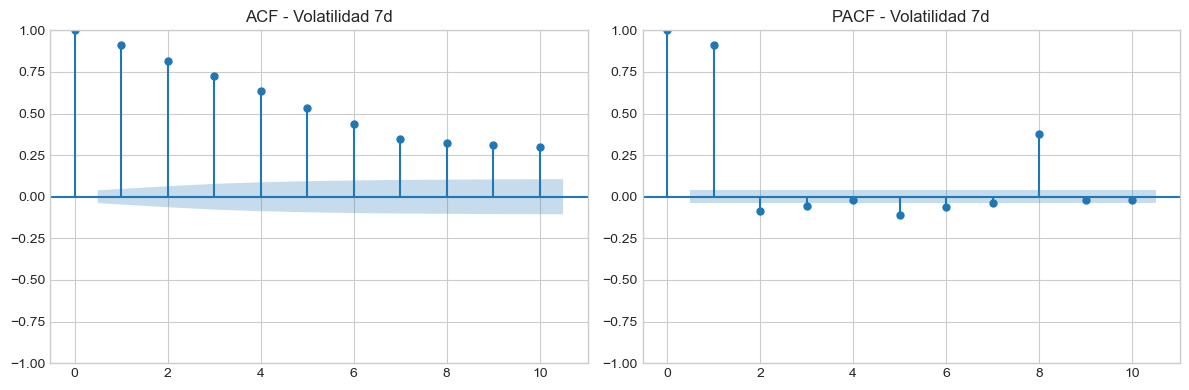

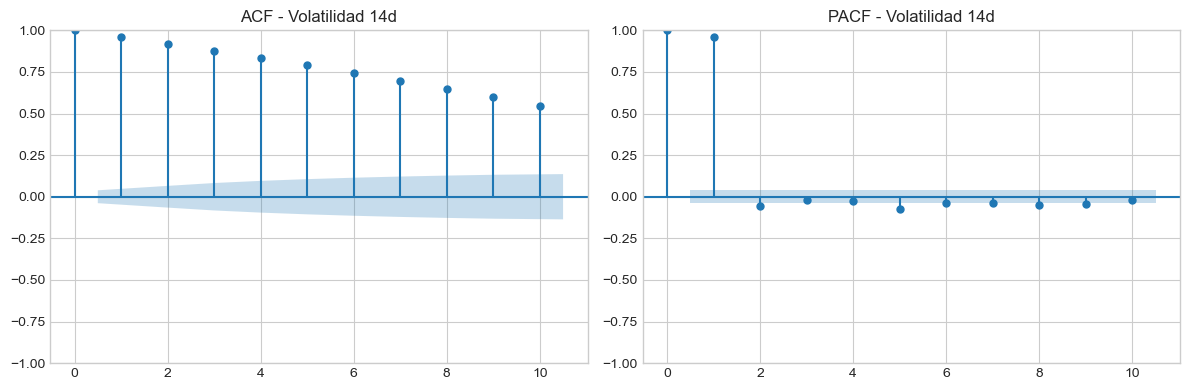

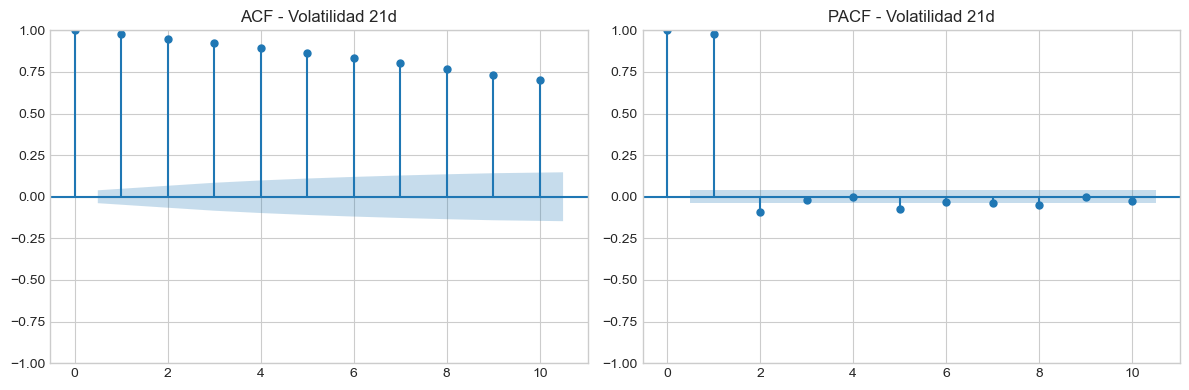

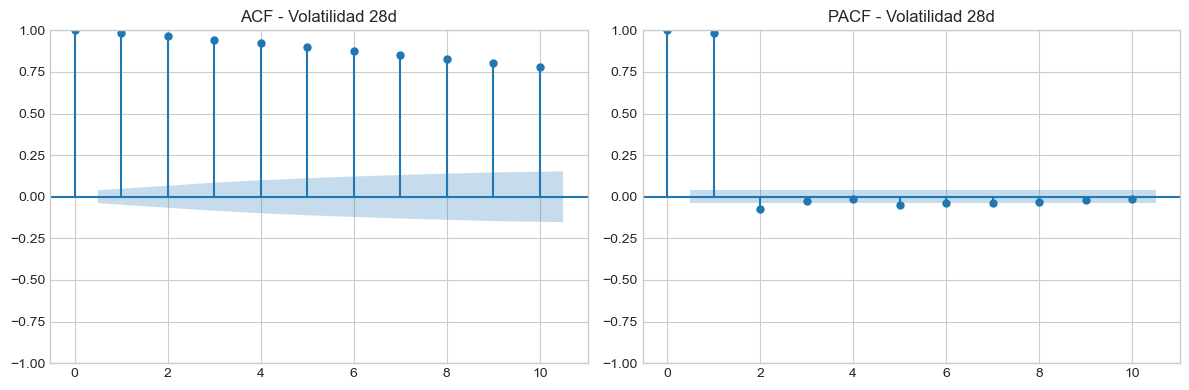

📊 Resultados de dependencia temporal por ventana:


,Ljung-Box stat,Ljung-Box p,Asimetría,Curtosis
Ventana,,,,
7d,8520.5384,0.0000e+00,3.0494,25.8341
14d,15375.8857,0.0000e+00,2.6499,18.4134
21d,18529.9222,0.0000e+00,2.3340,13.8887
28d,20294.3076,0.0000e+00,2.1402,11.3006


In [22]:
def analizar_dependencia_volatilidad(btc, ventanas, lags=10):
    resultados = []

    for v in ventanas:
        col = f"Volatil_D{v}"
        serie = btc[col].dropna()

        # Ljung-Box
        lb = acorr_ljungbox(serie, lags=[lags], return_df=True)
        lb_stat = lb['lb_stat'].values[0]
        lb_p = lb['lb_pvalue'].values[0]

        # Asimetría y curtosis
        skewness = skew(serie)
        kurt = kurtosis(serie, fisher=False)

        resultados.append({
            'Ventana': f'{v}d',
            'Ljung-Box stat': round(lb_stat, 4),
            'Ljung-Box p': f"{lb_p:.4e}",
            'Asimetría': round(skewness, 4),
            'Curtosis': round(kurt, 4)
        })

        # ACF y PACF
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        plot_acf(serie, ax=axes[0], lags=lags, title=f'ACF - Volatilidad {v}d')
        plot_pacf(serie, ax=axes[1], lags=lags, title=f'PACF - Volatilidad {v}d')
        plt.tight_layout()
        plt.show()

    # Tabla comparativa
    df_resultados = pd.DataFrame(resultados).set_index('Ventana')
    print("📊 Resultados de dependencia temporal por ventana:")

    return df_resultados
analizar_dependencia_volatilidad(btc, ventanas)